In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import arviz as az
import pymc3 as pm
plt.style.use('ggplot')

precipitations = pd.read_excel('data/weather_merignac.xlsx', sheet_name='precipitations_mm', index_col=0)
temp_maximals = pd.read_excel('data/weather_merignac.xlsx', sheet_name='temp_maximals', index_col=0)
temp_minimals = pd.read_excel('data/weather_merignac.xlsx', sheet_name='temp_minimals', index_col=0)
frost_days = pd.read_excel('data/weather_merignac.xlsx', sheet_name='frost_days_count', index_col=0)
severe_frost_days = pd.read_excel('data/weather_merignac.xlsx', sheet_name='severe_frost_days_count', index_col=0)
insulation = pd.read_excel('data/weather_merignac.xlsx', sheet_name='insulation', index_col=0)

ratings = pd.read_excel('data/ratings.xlsx')
#ratings = ratings[ratings['Category']=='Premier cru 1855']

#selected_vineyards = list(ratings['Chateau'].unique())
selected_vineyards = ['Château Lafite Rothschild Pauillac', 'Château Mouton Rothschild Pauillac', 'Château Latour Pauillac', 'Château Cheval Blanc', 'Château Ausone', 'Château Margaux', 'Château Haut-Brion Pessac-léognan', 'Château Angélus', 'Château Trotte Vieille', 'Château Palmer', 'Château Pavie', 'Petrus Pomerol', 'Château Léoville Las Cases Saint-Julien', 'Château Figeac', 'Château Pichon-Longueville Comtesse de Lalande Pauillac', 'Château Ducru-Beaucaillou Saint-Julien', 'Château Montrose Saint-Estèphe', 'Château Pichon-Longueville Baron Pauillac']
print(selected_vineyards)

ratings['Rating - Avg'] = (ratings['Rating - LB'] + ratings['Rating - HB'])/2
ratings = ratings.groupby('Vintage')['Rating - Avg'].mean().to_frame()


prices = pd.read_excel('data/prices.xlsx', index_col=0)
df = prices.drop('Category', axis=1).transpose().reset_index().melt(id_vars='index').rename(columns={'index':'Vintage', 'variable':'Chateau', 'value':'Price'})[['Chateau','Vintage','Price']]
df = df.replace(-100, np.NaN)
selected_prices = df[(df['Chateau'].isin(selected_vineyards))].fillna(method='ffill')
display(selected_prices['Chateau'].unique())
prices = selected_prices.groupby('Vintage')['Price'].mean().to_frame()

['Château Lafite Rothschild Pauillac', 'Château Mouton Rothschild Pauillac', 'Château Latour Pauillac', 'Château Cheval Blanc', 'Château Ausone', 'Château Margaux', 'Château Haut-Brion Pessac-léognan', 'Château Angélus', 'Château Trotte Vieille', 'Château Palmer', 'Château Pavie', 'Petrus Pomerol', 'Château Léoville Las Cases Saint-Julien', 'Château Figeac', 'Château Pichon-Longueville Comtesse de Lalande Pauillac', 'Château Ducru-Beaucaillou Saint-Julien', 'Château Montrose Saint-Estèphe', 'Château Pichon-Longueville Baron Pauillac']


array(['Château Lafite Rothschild Pauillac', 'Château Latour Pauillac',
       'Château Mouton Rothschild Pauillac', 'Château Margaux',
       'Château Haut-Brion Pessac-léognan',
       'Château Pichon-Longueville Baron Pauillac',
       'Château Pichon-Longueville Comtesse de Lalande Pauillac',
       'Château Montrose Saint-Estèphe',
       'Château Ducru-Beaucaillou Saint-Julien',
       'Château Léoville Las Cases Saint-Julien', 'Château Ausone',
       'Château Cheval Blanc', 'Château Pavie', 'Château Figeac',
       'Château Trotte Vieille', 'Château Angélus', 'Château Palmer',
       'Petrus Pomerol'], dtype=object)

# Feature engineering. #TODO: implement "Exceptional past year"

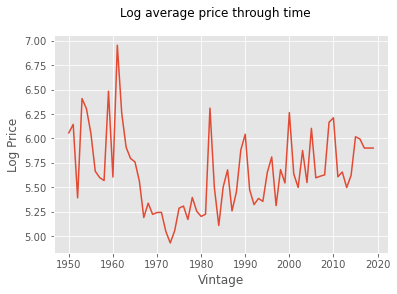

In [2]:
y = prices
y['Log Price'] = np.log(y['Price'])
sns.lineplot(data=y['Log Price'])
plt.suptitle('Log average price through time')
plt.show()

In [4]:
X = pd.DataFrame(index = precipitations.index).loc[1950:]

X['Winter Rain'] =  precipitations.shift(1)['Dec'] # really important


X['Harvest Rain'] =  precipitations['Mai']+precipitations['Jui']+precipitations['Juil']+precipitations['Aou']+ precipitations['Sep']*2


X['Winter Temperature'] = \
    (temp_maximals.shift(1)['Dec'] + temp_minimals.shift(1)['Dec'])+\
    (temp_maximals['Jan'] + temp_minimals['Jan'])+\
    (temp_maximals['Fev'] + temp_minimals['Fev'])

X['Square Winter Temperature'] = X['Winter Temperature']**2

X['Summer Temperature'] = \
    (temp_maximals['Mai'] + temp_minimals['Mai'])+\
    (temp_maximals['Jui'] + temp_minimals['Jui'])*2+\
    (temp_maximals['Juil'] + temp_minimals['Juil'])

X['Square Summer Temperature'] = X['Summer Temperature']**2


X['Harvest Temperature'] = \
                    (temp_maximals['Aou'] + temp_minimals['Aou'])+\
                    (temp_maximals['Sep'] + temp_minimals['Sep'])*3+\
                    (temp_maximals['Oct'] + temp_minimals['Oct'])*2


X['Square Harvest Temperature'] = X['Harvest Temperature']**2

#X['Past Year Quality'] = y['Log Price'].shift(1).fillna(0) - y['Log Price'].rolling(10).mean().shift(1).fillna(0)

X['Frost Days'] = frost_days['Mar']+ 3*frost_days['Avr']+ 3*(frost_days['Mai'] + frost_days['Jui'])

#X['Severe Frost Days'] = (severe_frost_days['Sep'].shift(1).fillna(0) + severe_frost_days['Oct'].shift(1).fillna(0) + severe_frost_days['Nov'].shift(1).fillna(0))*3 + severe_frost_days['Dec'].shift(1).fillna(0)*2 + severe_frost_days['Jan'] + severe_frost_days['Fev'] + severe_frost_days['Mar']*2 + severe_frost_days['Mar']*3

X['Frost Days Prev Fall'] = 2*frost_days['Oct'].shift(1).fillna(0)+ frost_days['Nov'].shift(1).fillna(0)
+ frost_days['Dec'].shift(1).fillna(0)
display(X.tail())
#X['Insulation'] = insulation.iloc[:,0] # negative on mean r2 and bad scores

,Winter Rain,Harvest Rain,Winter Temperature,Square Winter Temperature,Summer Temperature,Square Summer Temperature,Harvest Temperature,Square Harvest Temperature,Frost Days,Frost Days Prev Fall
Year,,,,,,,,,,
2015,54.3,273.1,40.3,1624.09,163.0,26569.00,204.5,41820.25,0,0.0
2016,12.5,321.3,57.1,3260.41,151.1,22831.21,225.8,50985.64,2,2.0
2017,13.2,402.7,45.1,2034.01,166.7,27788.89,213.6,45624.96,0,0.0
2018,162.7,180.9,42.9,1840.41,164.6,27093.16,230.7,53222.49,1,5.0
2019,93.2,348.4,52.2,2724.84,157.9,24932.41,230.3,53038.09,0,2.0


# Building an exploratory model

In [5]:
from sklearn.preprocessing import StandardScaler

X = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns).loc[1950:,:]

column_names = X.columns.to_list()
print(column_names)
display(X.head())
print(X.info())

['Winter Rain', 'Harvest Rain', 'Winter Temperature', 'Square Winter Temperature', 'Summer Temperature', 'Square Summer Temperature', 'Harvest Temperature', 'Square Harvest Temperature', 'Frost Days', 'Frost Days Prev Fall']


,Winter Rain,Harvest Rain,Winter Temperature,Square Winter Temperature,Summer Temperature,Square Summer Temperature,Harvest Temperature,Square Harvest Temperature,Frost Days,Frost Days Prev Fall
Year,,,,,,,,,,
1950,-0.282566,-0.803884,-0.143311,-0.245015,0.977377,0.970678,-1.231039,-1.209824,0.778488,1.878762
1951,0.551058,0.788200,-0.716208,-0.775239,-1.075396,-1.064147,-1.136901,-1.123388,0.937828,-0.355010
1952,-0.119711,-0.023537,-0.984372,-1.000442,0.414973,0.382887,-1.745179,-1.671537,0.619148,-0.075789
1953,2.268292,-0.600950,-1.776675,-1.580183,-1.066022,-1.055548,-0.456209,-0.480912,-0.018210,0.482654
1954,-1.487049,-0.554231,-0.338340,-0.433028,-1.769027,-1.682840,-0.731382,-0.744333,0.141129,0.203433


<class 'pandas.core.frame.DataFrame'>
Int64Index: 70 entries, 1950 to 2019
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Winter Rain                 70 non-null     float64
 1   Harvest Rain                70 non-null     float64
 2   Winter Temperature          70 non-null     float64
 3   Square Winter Temperature   70 non-null     float64
 4   Summer Temperature          70 non-null     float64
 5   Square Summer Temperature   70 non-null     float64
 6   Harvest Temperature         70 non-null     float64
 7   Square Harvest Temperature  70 non-null     float64
 8   Frost Days                  70 non-null     float64
 9   Frost Days Prev Fall        70 non-null     float64
dtypes: float64(10)
memory usage: 6.0 KB
None


In [ ]:
pm.traceplot(trace['nu'])
pm.traceplot(trace['sigma intercept'])
pm.traceplot(trace['sigma coeffs'])

Runtime of below, 
- when having to estimate sigma coeffs, sigma intercept and nu: 8min35, 7min17, 7min13
- when sigma coeffs, sigma intercept and nu are fixed: 5min55, 5min33, 5min50, less errors

In [7]:
CONSTANT_COEFFS = ['Harvest Temperature', 'Square Harvest Temperature',\
                   'Summer Temperature', 'Square Summer Temperature',\
                   'Winter Temperature', 'Square Winter Temperature',\
                  'Harvest Rain']

## Findings:

- Harvest Temperature et Square Harvest Temperature: les GaussianRandomWalk sont constantes (a 1.6 et -1.6), donc on peut les remplacer par des constantes
- Winter Temperature et Square Winter Temperature: les GaussianRandomWalk sont constantes (a -0.4 et 0.4), donc on peut les remplacer par des constantes
- Le temps de recherche semple a peu pres proportionnel au nombre de GaussianRandomWalk
- GaussianRandomWalk for Frost Days shows their impact has nearly vanished in recent years. Therefore it adds small benefits to the study
- Past year quality seems to introduce bad inertia in the predictions
- Cold injury to grapevines may result from the winter minimum temperature; spring temperatures below -0.6°C, which may damage developing buds and shoots; or fall temperatures below -0.6°C, which may injure maturing canes and berries.
- Intercept is very flat in recent years when winter rain coeff is held fixed (positive value) (and therefore too high, causing too much variation). This could mean that the work on winter rain by the vineyards allows to compensate for the lack of it.

In [8]:
import pymc3 as pm # Last correct version: 3.7.0

with pm.Model() as model_global:
    #sigma_coeffs = pm.Exponential('sigma coeffs', 1/.01, testval=1) # Random walk jump size
    #sigma_intercept = pm.Exponential('sigma intercept', 1/.01, testval=1) # Random walk jump size
    sigma_coeffs = 0.013
    sigma_intercept = 0.055
    #nu = pm.Exponential('nu', 1./0.2) # Observation noise
    nu = 0.255
    column_names_short = [i for i in column_names if i not in CONSTANT_COEFFS]
    
    coeffs = [(pm.GaussianRandomWalk(coeff_name, mu=0, sigma=sigma_coeffs, shape=len(y)), coeff_name) \
                for coeff_name in column_names_short]
    coeffs.append((pm.Normal('Harvest Temperature', mu=1.6, sd=0.3), 'Harvest Temperature'))
    coeffs.append((pm.Normal('Square Harvest Temperature', mu=-1.5, sd=0.3), 'Square Harvest Temperature'))
    coeffs.append((pm.Normal('Winter Temperature', mu=-0.4, sd=0.3), 'Winter Temperature'))
    coeffs.append((pm.Normal('Square Winter Temperature', mu=0.4, sd=0.3), 'Square Winter Temperature'))
    coeffs.append((pm.Normal('Summer Temperature', mu=0.5, sd=0.3), 'Summer Temperature'))
    coeffs.append((pm.Normal('Square Summer Temperature', mu=-0.5, sd=0.3), 'Square Summer Temperature'))
    
    coeffs.append((pm.Normal('Harvest Rain', mu=-0.1, sd=0.1), 'Harvest Rain'))
    #coeffs.append((pm.Normal('Severe Frost Days', mu=-0.05, sd=0.05), 'Severe Frost Days'))

    #coeffs.append((pm.Normal('Winter Rain', mu= 0.6, sd=0.1), 'Harvest Rain'))

    #coeffs.append((pm.Normal('Past Year Quality', mu=0.07, sd=0.2), 'Past Year Quality'))

    intercept = pm.GaussianRandomWalk('intercept', mu=0, sigma=sigma_intercept, shape=len(y))
    
    mu = 6 + intercept 
    for (coeff, coeff_name) in coeffs:
        mu += coeff * X[coeff_name]
        
    observed = pm.Normal('observed', mu, sd=nu, observed=y['Log Price'])
    trace_global = pm.sample(2000,chains=2, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [intercept, Harvest Rain, Square Summer Temperature, Summer Temperature, Square Winter Temperature, Winter Temperature, Square Harvest Temperature, Harvest Temperature, Frost Days Prev Fall, Frost Days, Winter Rain]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 5000/5000 [05:45<00:00, 14.49draws/s]


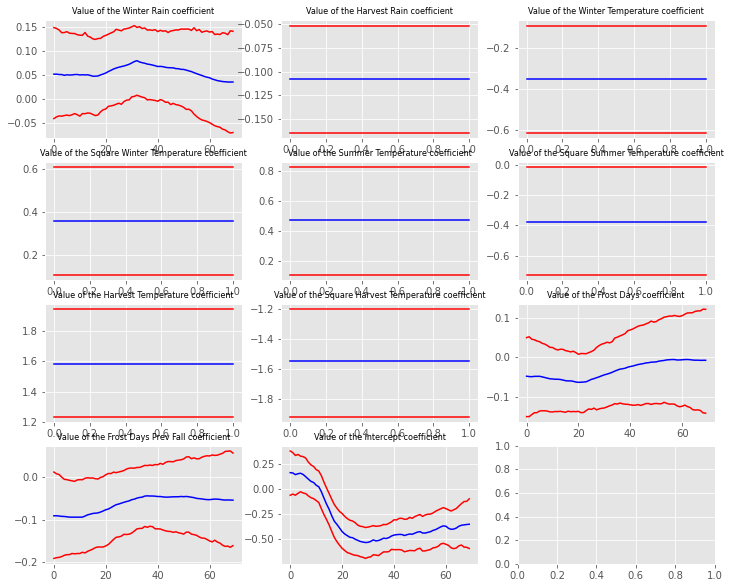

In [11]:
mean, high_95, low_95 = extract_quantities_from_trace(trace_global, 1000, model_global)

all_names = column_names+['intercept']

f, axs = plt.subplots(len(all_names)//3+1, 3)
f.set_size_inches(12,10)
for i in range(len(all_names)):
    coeff_name = all_names[i]
    subplot = axs[i//3, i%3]

    if coeff_name in CONSTANT_COEFFS:
        subplot.plot([mean[coeff_name]]*2, color='blue')
        subplot.plot([high_95[coeff_name]]*2, color='r')
        subplot.plot([low_95[coeff_name]]*2, color='r')
    else:
        subplot.plot(mean[coeff_name], color='blue')
        subplot.plot(high_95[coeff_name], color='r')
        subplot.plot(low_95[coeff_name], color='r')
    subplot.set_title('Value of the '+coeff_name+' coefficient', fontsize=8)
plt.show()

So far, this looks really good. Notice how the harvest temperature decreases to 0: a quadratic effect could be reached.

## Plotting results

In [12]:
X_vintage = X
vintage_index = X_vintage.index.values

coeff_list = [str(coeff) for coeff in model_global.free_RVs]
mean_HMC_global = extract_mean_from_trace(trace_global, 1000, model_global)
predictions=[]
for vintage in range(1994, 2016):
    prediction = 6
    for coeff in coeff_list:
        if coeff == 'intercept':
            prediction += mean_HMC_global['intercept'][vintage-1950]
        elif coeff in CONSTANT_COEFFS:
            prediction += mean_HMC_global[coeff] * X_vintage[coeff][vintage]
        else:
            prediction += mean_HMC_global[coeff][vintage-1950] * X_vintage[coeff][vintage]
    predictions.append(prediction)

print(predictions)

full_predictions=[]
for vintage in range(1950, 2016):
    prediction = 6
    for coeff in coeff_list:
        if coeff == 'intercept':
            prediction += mean_HMC_global['intercept'][vintage-1950]
        elif coeff in CONSTANT_COEFFS:
            prediction += mean_HMC_global[coeff] * X_vintage[coeff][vintage]
        else:
            prediction += mean_HMC_global[coeff][vintage-1950] * X_vintage[coeff][vintage]
    full_predictions.append(prediction)

[5.591023829454923, 5.754099432383459, 5.5967400514214996, 5.504332500214693, 5.693161873358568, 5.399370471391718, 5.845614280441509, 5.930911561748058, 5.643286333073301, 5.895536906932561, 5.72781094569261, 5.935428023097355, 5.687468714919781, 5.684862058489471, 5.585006624212375, 5.824407725109371, 5.912955734841612, 5.810720781086485, 5.884814157204294, 5.5908240523485215, 5.780079359729128, 5.902835848206052]


From -30 to -5
### With all 5 base features + square harvest temperature:

Spearman correlation between results and real log prices: 
 0.7684615384615385
 
R2 between results and real log prices: 
 -0.052318688276817404
 
### With all 5 base features + square harvest, summer and winter:



###### Winter temp coeff initialized to: temperature negative, square winter temp positive

Spearman correlation between results and real log prices: 
 0.7430769230769232
 
R2 between results and real log prices: 
 -0.12716061931460976

###### Only summer and summer square random walks, summer taking -0.5 coeff and square 0.5 (weird), with frost days
Spearman correlation between results and real log prices: 
 0.7846153846153846

R2 between results and real log prices: 
 0.020928624681028296

MAE between results and real log prices: 
 0.16046999698162723
 
##### All temperatures constant, summer and summer square corrected different than gaussian, with frost days
Spearman correlation between results and real log prices: 
 0.7576923076923077

R2 between results and real log prices: 
 -0.11866645665076758

MAE between results and real log prices: 
 0.16319599034664248
 
 
##### All temperatures constant, summer and summer square corrected different than gaussian, without frost days

Spearman correlation between results and real log prices: 
 0.7669230769230769

R2 between results and real log prices: 
 -0.05875304209724219

MAE between results and real log prices: 
 0.16520215994075993



 
 
# last:

Spearman correlation between results and real log prices: 
 0.7638461538461538

R2 between results and real log prices: 
 -0.03504733390556325

MAE between results and real log prices: 
 0.16676518887458794


## With last year
Spearman correlation between results and real log prices: 
 0.7638461538461538

R2 between results and real log prices: 
 0.007120330611151915

MAE between results and real log prices: 
 0.1652437894521807


## Without

Spearman correlation between results and real log prices: 
 0.7623076923076924

R2 between results and real log prices: 
 -0.06744059329139218

MAE between results and real log prices: 
 0.16599584729482167


# With frost days

Spearman correlation between results and real log prices: 
 0.7500000000000001

R2 between results and real log prices: 
 -0.035866925565070096

MAE between results and real log prices: 
 0.1633591301731515
 
# All temperatures squared, without frost days, constant past year coeff
Spearman correlation between results and real log prices: 
 0.7607692307692308

R2 between results and real log prices: 
 -0.035086062969645004

MAE between results and real log prices: 
 0.16631474557967058
 
 # All temperatures squared, without frost days, without constant past year coeff
Spearman correlation between results and real log prices: 
 0.7676923076923077

R2 between results and real log prices: 
 -0.08081224678691878

MAE between results and real log prices: 
 0.1667579538015844

# Good timeframe:
## All temperatures squared, without frost days, without constant past year coeff

Spearman correlation between results and real log prices: 
 0.6747600225861097

R2 between results and real log prices: 
 -1.6422676028126628

MAE between results and real log prices: 
 0.17478571140093943
 
## All temperatures squared, with frost days, without constant past year coeff

Spearman correlation between results and real log prices: 
 0.6781479390175044

R2 between results and real log prices: 
 -1.5863198430642451

MAE between results and real log prices: 
 0.175002870302688

## Same, with frost days previous fall
Spearman correlation between results and real log prices: 
 0.7312252964426879

R2 between results and real log prices: 
 -0.8911699340879837

MAE between results and real log prices: 
 0.17375032490948739

## With previous fall frost, with fixed harvest rain coeff (1)
Spearman correlation between results and real log prices: 
 0.7334839073969509

R2 between results and real log prices: 
 -0.8797738551856586

MAE between results and real log prices: 
 0.1727914376727142

## Same with fixed winter rain coeff
Spearman correlation between results and real log prices: 
 0.6792772444946359
 
Spearman correlation between results and real log prices / full: 
 0.6429600250495774

R2 between results and real log prices: 
 0.27337619689911097
 
R2 between results and real log prices / full: 
 0.4453358799007586

MAE between results and real log prices: 
 0.25131598245402026
 
MAE between results and real log prices / full: 
 0.3212069697014027
 
## Same as (1) with added randwalk severe frost. Best overall, maybe too complex
 Spearman correlation between results and real log prices: 
 0.7380011293054772
Spearman correlation between results and real log prices / full: 
 0.8213965139338276

R2 between results and real log prices: 
 -0.6051822826563602
R2 between results and real log prices / full: 
 0.33130427534546625

MAE between results and real log prices: 
 0.17033322238971235
MAE between results and real log prices / full: 
 0.1885801028000424
 
 
## Same as (1) with constant severe frost. Pas fifou

Spearman correlation between results and real log prices: 
 0.7346132128740825
 
Spearman correlation between results and real log prices / full: 
 0.81960129422816

R2 between results and real log prices: 
 -0.6513908159689121
 
R2 between results and real log prices / full: 
 0.3169059930796698

MAE between results and real log prices: 
 0.17006547692658838
 
MAE between results and real log prices / full: 
 0.18971257806324726
 
## Same as (1) with un poil de cul meilleur choix de prev fall frost

Spearman correlation between results and real log prices: 
 0.7368718238283457
Spearman correlation between results and real log prices / full: 
 0.8170963364993217

R2 between results and real log prices: 
 -0.5703578937351272
R2 between results and real log prices / full: 
 0.32404061158665254

MAE between results and real log prices: 
 0.1700733117683792
MAE between results and real log prices / full: 
 0.1903584165921395

## Meme qu'au dessus, sans le severe frost

Spearman correlation between results and real log prices: 
 0.7289666854884248
 
Spearman correlation between results and real log prices / full: 
 0.8189750547959505

R2 between results and real log prices: 
 -0.8755691845055305
 
R2 between results and real log prices / full: 
 0.32729170605817537

MAE between results and real log prices: 
 0.1726783150829025
 
MAE between results and real log prices / full: 
 0.18909051393308876

Spearman correlation between results and real log prices: 
 0.7380011293054772
Spearman correlation between results and real log prices / full: 
 0.8183905646592216

R2 between results and real log prices: 
 -0.8301392207101883
R2 between results and real log prices / full: 
 0.3213359690438776

MAE between results and real log prices: 
 0.17154519354259595
MAE between results and real log prices / full: 
 0.18879702485013405


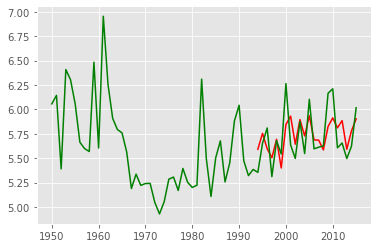

In [13]:
from scipy.stats import spearmanr
from sklearn.metrics import r2_score

y = y.loc[1950:2015]
plt.plot(range(1994, 2016), predictions, color='r')
plt.plot(y['Log Price'], color='g')
print('Spearman correlation between results and real log prices: \n', spearmanr(predictions, y.loc[1994:2015, 'Log Price']).correlation)
print('Spearman correlation between results and real log prices / full: \n', spearmanr(full_predictions, y['Log Price']).correlation)

print('\nR2 between results and real log prices: \n', r2_score(predictions, y.loc[1994:2015, 'Log Price']))
print('R2 between results and real log prices / full: \n', r2_score(full_predictions, y['Log Price']))

print('\nMAE between results and real log prices: \n', np.mean(np.abs(predictions - y.loc[1994:2015, 'Log Price'])))
print('MAE between results and real log prices / full: \n', np.mean(np.abs(full_predictions - y['Log Price'])))

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

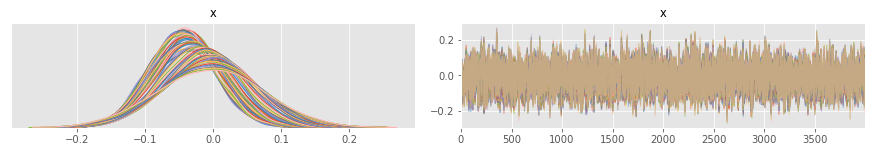

In [210]:
import warnings
warnings.filterwarnings("ignore")
pm.traceplot(trace_global['Frost Days'].T)

In [135]:
az.summary(trace_global)['r_hat']

Winter Rain[0]    1.0
Winter Rain[1]    1.0
Winter Rain[2]    1.0
Winter Rain[3]    1.0
Winter Rain[4]    1.0
                 ... 
intercept[65]     1.0
intercept[66]     1.0
intercept[67]     1.0
intercept[68]     1.0
intercept[69]     1.0
Name: r_hat, Length: 216, dtype: float64

<AxesSubplot:>

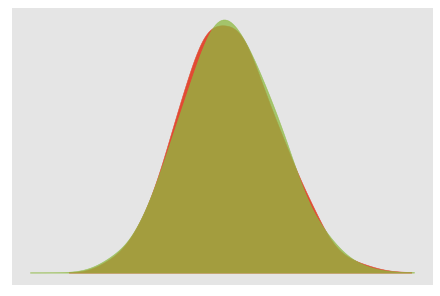

In [136]:
pm.energyplot(trace_global, legend=False, figsize=(6, 4))

# All mobile coeffs predictive model

The procedure will go as follows to predict the quality of one year: the HMC model will be run for up to the predicted model, the mean will then be interpolated by a polynomial, and the prolongation of the said polynomial will finally give the value of the coefficients for the next year, thus leading to a prediction.

In [10]:
def extrapolate_next_coefficients(vintage_index, mean_dict):
    next_coeff_values={}
    for coeff in mean_dict.keys():
        z = np.polyfit(vintage_index[-10:], mean_dict[coeff][-10:], 2)
        p = np.poly1d(z)
        plt.plot(vintage_index, mean_dict[coeff], color='green')
        plt.plot(vintage_index[-10:], p(vintage_index)[-10:], color='orange')
        plt.show()
        next_coeff_values[coeff] = p(vintage_index[-1]+1)
    return next_coeff_values

def extract_mean_from_trace(trace, getback, model):
    coeffs = [str(coeff) for coeff in model.free_RVs]
    mean_dict = {}
    for coeff in coeffs:
        if coeff in CONSTANT_COEFFS:
            mean_dict[coeff] = np.mean(trace[coeff][-getback:])
        else:
            mean_dict[coeff] = np.mean(trace[coeff][-getback:, :], axis=0)
    return mean_dict

def extract_quantities_from_trace(trace, getback, model):
    coeffs = [str(coeff) for coeff in model.free_RVs]
    mean, high_95, low_95 = {}, {}, {}
    for coeff in coeffs:
        if coeff in CONSTANT_COEFFS:
            mean[coeff] = np.mean(trace[coeff][-getback:])
            high_95[coeff] = np.quantile(trace[coeff][-getback:], 0.95)
            low_95[coeff] = np.quantile(trace[coeff][-getback:], 0.05)

            
        else:
            mean[coeff] = np.mean(trace[coeff][-getback:, :], axis=0)
            high_95[coeff] = np.quantile(trace[coeff][-getback:], 0.95, axis=0)
            low_95[coeff] = np.quantile(trace[coeff][-getback:], 0.05, axis=0)

    return mean, high_95, low_95


In [14]:
def get_HMC_mean_curves(X, y, vintage, fixed_coeffs=None):
    print('Building curves for vintage ', vintage)
    X_vintage = X.loc[:vintage-1, :]
    y_vintage = y.loc[:vintage-1, :]
    
    with pm.Model() as model:
        #sigma_coeffs = pm.Exponential('sigma coeffs', 1/.01, testval=1) # Random walk jump size
        #sigma_intercept = pm.Exponential('sigma intercept', 1/.01, testval=1) # Random walk jump size
        sigma_coeffs = 0.013
        sigma_intercept = 0.055
        #nu = pm.Exponential('nu', 1./0.2) # Observation noise
        nu = 0.255
        column_names_short = [i for i in column_names if i not in CONSTANT_COEFFS]
        
        coeffs = [(pm.GaussianRandomWalk(coeff_name, mu=0, sigma=sigma_coeffs, shape=len(y_vintage)), coeff_name) \
                    for coeff_name in column_names_short]
        if fixed_coeffs==None:
            coeffs.append((pm.Normal('Harvest Temperature', mu=1.6, sd=0.3), 'Harvest Temperature'))
            coeffs.append((pm.Normal('Square Harvest Temperature', mu=-1.5, sd=0.3), 'Square Harvest Temperature'))
            coeffs.append((pm.Normal('Winter Temperature', mu=-0.4, sd=0.3), 'Winter Temperature'))
            coeffs.append((pm.Normal('Square Winter Temperature', mu=0.4, sd=0.3), 'Square Winter Temperature'))
            coeffs.append((pm.Normal('Summer Temperature', mu=0.5, sd=0.3), 'Summer Temperature'))
            coeffs.append((pm.Normal('Square Summer Temperature', mu=-0.5, sd=0.3), 'Square Summer Temperature'))
                
            
        intercept = pm.GaussianRandomWalk('intercept', mu=0, sigma=sigma_intercept, shape=len(y_vintage))
        
        mu = 6 + intercept 
        for (coeff, coeff_name) in coeffs:
            mu += coeff * X_vintage[coeff_name]
            
        if fixed_coeffs !=None:
            for coeff in list(fixed_coeffs.keys()):
                mu += fixed_coeffs[coeff] * X_vintage[coeff]
            
        observed = pm.Normal('observed', mu, sd=nu, observed=y_vintage['Log Price'])
        trace = pm.sample(2500,chains=2, target_accept=0.9)
        
    mean_dict = extract_mean_from_trace(trace, 1500, model)
    return mean_dict

In [15]:
HMC = {}
HMC[1994] = get_HMC_mean_curves(X,y, 1994, fixed_coeffs=None)
fixed_coeffs = {}
for coeff in CONSTANT_COEFFS:
    fixed_coeffs[coeff] = HMC[1994][coeff]
    
for vintage in range(1995, 2016):
    HMC[vintage]= get_HMC_mean_curves(X,y, vintage, fixed_coeffs=fixed_coeffs)

Building curves for vintage  1994


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [intercept, Square Summer Temperature, Summer Temperature, Square Winter Temperature, Winter Temperature, Square Harvest Temperature, Harvest Temperature, Frost Days Prev Fall, Frost Days, Winter Rain]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [04:25<00:00, 22.61draws/s]


KeyError: 'Harvest Rain'

In [196]:
def predict_from_HMC_curves(HMC, HMC_stop_date, vintage, plot=False):
    #print('Predicting for vintage: ', vintage)
    mean_HMC = HMC[HMC_stop_date]

    vintage_index = range(1950, HMC_stop_date)
        
    if plot:
        f, axs = plt.subplots((len(mean_HMCs.keys())-len(CONSTANT_COEFFS))//3, 3)

    next_coeff_values={}
    coeff_names = list(mean_HMC.keys())
    
    for i in range(len(coeff_names)):
        coeff = coeff_names[i]
        if coeff in CONSTANT_COEFFS:
            next_coeff_values[coeff] = mean_HMC[coeff]
        else:
            z = np.polyfit(vintage_index[-10:], mean_HMC[coeff][-10:], 1)
            p = np.poly1d(z)
            next_coeff_values[coeff] = np.mean(mean_HMC[coeff][-10:])# p(vintage) #    
        
            if plot:
                subplot = axs[i//3, i%3]
                subplot.plot(vintage_index, mean_HMC[coeff], color='green')
                subplot.plot(vintage_index[-20:], p(vintage_index)[-20:], color='orange')
                subplot.set_title(coeff)

    plt.show()
        

    return next_coeff_values

In [200]:
predictions=[]
coeff_record = {}
for coeff_name in column_names+['intercept']:
    coeff_record[coeff_name] = []
    
next_coeff_values = predict_from_HMC_curves(mean_HMC, vintage, vintage, plot=False)



for vintage in range(1994, 2016):
    print(vintage)
      
    next_coeff_values = predict_from_HMC_curves(mean_HMC, vintage, vintage, plot=False)
    if vintage==1994:
        next_coeff_values_1994 = next_coeff_values
      
    prediction = 6 + next_coeff_values['intercept'] + (vintage-1994)*0.005
    for coeff in column_names:
        if coeff in CONSTANT_COEFFS:
            prediction += next_coeff_values_1994[str(coeff)] * X.loc[vintage, str(coeff)]
        else:#############################attention cést tjrs 1994
            prediction += next_coeff_values_1994[str(coeff)] * X.loc[vintage, str(coeff)]
        
        
    
    #prediction = 6 + mean_HMC_global['intercept'] [vintage-1950]
    #for coeff in column_names:
    #    if coeff in CONSTANT_COEFFS:
    #        prediction += mean_HMC_global[str(coeff)] * X.loc[vintage, str(coeff)]
    #    else:#############################attention cést tjrs 1994
    #        prediction += mean_HMC_global[str(coeff)][vintage-1950] * X.loc[vintage, str(coeff)]
        
        
        
    for coeff in column_names+['intercept']:
        if vintage==1994 or coeff not in CONSTANT_COEFFS:
            coeff_record[coeff].append(next_coeff_values[coeff])
    predictions.append(prediction) 
    
print(coeff_record['intercept'])

1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
[-0.4876113139557458, -0.5245863650251038, -0.5257288127970549, -0.5031829993786746, -0.5319011711551521, -0.5356018455732602, -0.5444900443092341, -0.4762500581437138, -0.5111942675093335, -0.5119510362239605, -0.5000829477070657, -0.513515145116436, -0.47859714741405385, -0.48652081249662305, -0.4691308509997586, -0.45554477364896906, -0.4122919313228435, -0.3744812130444959, -0.38337927636176194, -0.39948595362662503, -0.4176881030082595, -0.4398353518574497]


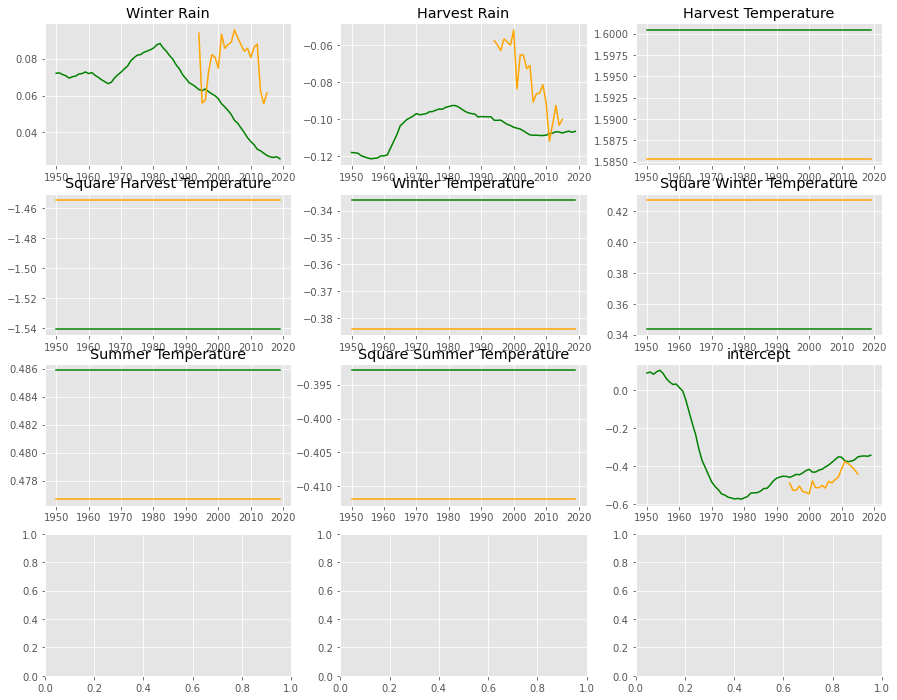

In [201]:
mean_HMC_global = extract_mean_from_trace(trace_global, 1000, model_global)

plt.rcParams['figure.figsize']= [15, 12]
f, axs = plt.subplots(4, 3)
coeff_list = list(mean_HMC_global.keys())
for i in range(len(coeff_list)):
    coeff = coeff_list[i]
    subplot = axs[i//3, i%3]
    if coeff in CONSTANT_COEFFS:
        subplot.plot(range(1950, 2020), [mean_HMC_global[coeff]]*70, color='green')
        subplot.plot(range(1950, 2020), [coeff_record[coeff]]*70, color='orange')

    else:
        subplot.plot(range(1950, 2020), mean_HMC_global[coeff], color='green')
        subplot.plot(range(1994, 2016), coeff_record[coeff], color='orange')

        
    subplot.set_title(coeff) 


Spearman correlation: 
0.11688311688311688

R2 score: 
-0.17443400405224363


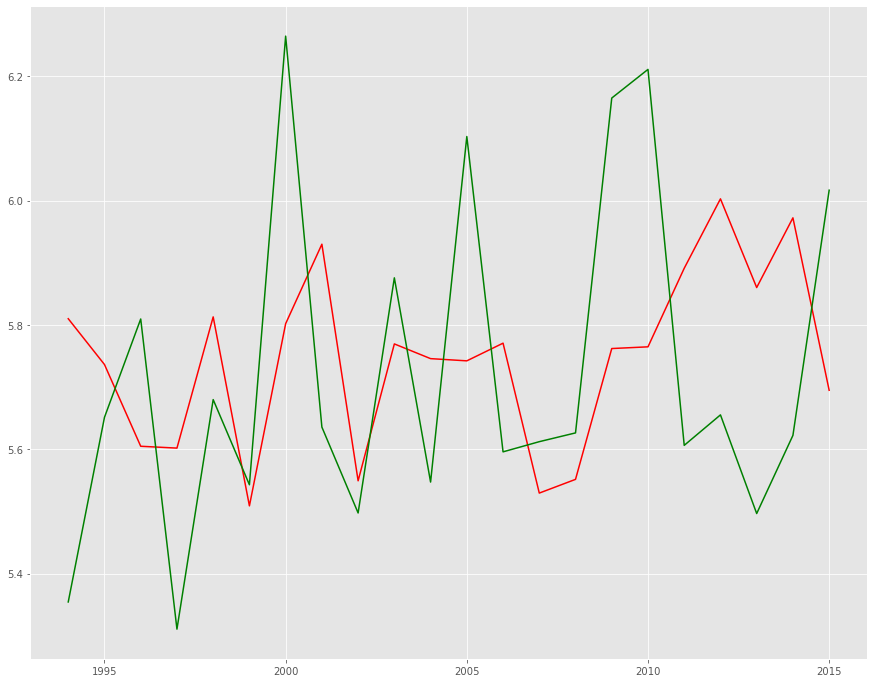

In [202]:
from scipy.stats import spearmanr
from sklearn.metrics import r2_score

plt.plot(y.loc[1994:2015, 'Log Price'].index, predictions, color='r')
plt.plot(y.loc[1994:2015, 'Log Price'], color='g')

print('\nSpearman correlation: ')
print(spearmanr(y.loc[1994:2015, 'Log Price'], predictions).correlation)

print('\nR2 score: ')
print(r2_score(y.loc[1994:2015, 'Log Price'], predictions))

### Avec fenetre maximale, bcp de parametres, prediction dde 1994 a 2015 selon des parametres de tous les 10 ans:

Spearman correlation: 
SpearmanrResult(correlation=0.39582156973461324, pvalue=0.06822788864462451)

R2 score: 
0.025302295991555313

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

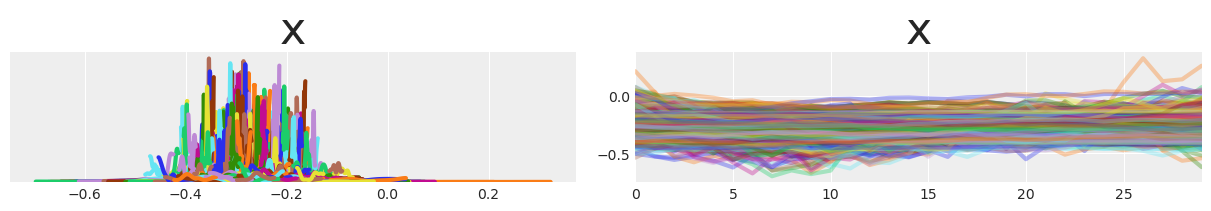